In [ ]:
! pip install -U kaggle fastkaggle fastcore fastai

In [5]:
from fastkaggle import *

In [6]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [7]:
path

Path('paddy-disease-classification')

In [8]:
from fastai.vision.all import *

In [9]:
trn_path = path/'sml'

In [10]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

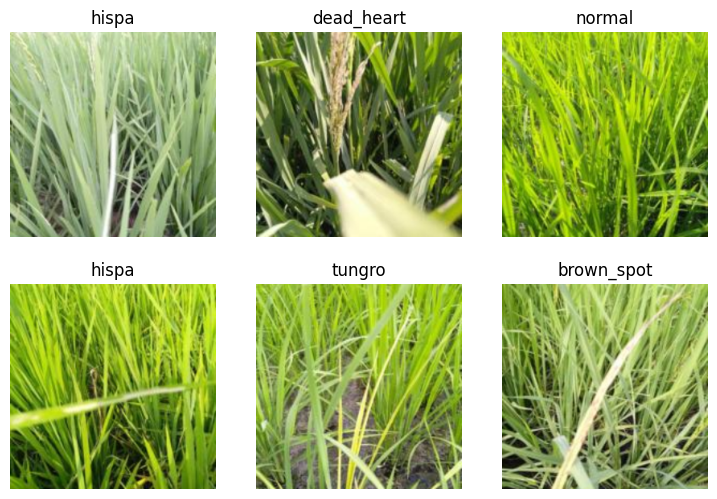

In [11]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2,
    item_tfms=Resize(256, 192))

dls.show_batch(max_n=6)

In [12]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [16]:
learn = train('resnet26d', item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

In [17]:
learn = train('convnext_small_in22k', item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

In [19]:
learn = train('convnext_small_in22k',
              item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=128, min_scale=0.75))

In [21]:
valid = learn.dls.valid
preds, targs = learn.get_preds(dl=valid)

In [24]:
error_rate(preds, targs)

TensorBase(0.0432)

In [25]:
tta_preds, _ = learn.tta(dl=valid)

In [26]:
error_rate(tta_preds, targs)

TensorBase(0.0336)

In [27]:
trn_path = path / 'train_images'

In [28]:
learn = train('convnext_small_in22k',
              item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=128, min_scale=0.75),
              epochs=12)

In [29]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0255)

In [30]:
tst_files = get_image_files(path / 'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [31]:
probs, _ = learn.tta(dl=tst_dl)

In [33]:
preds= probs

In [34]:
idxs = preds.argmax(dim=1)

In [35]:
idxs[0]

tensor(7)

In [36]:
results = pd.Series(learn.dls.vocab[idxs])
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Length: 3469, dtype: object

In [37]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

image_id  label
0     200001.jpg    NaN
1     200002.jpg    NaN
2     200003.jpg    NaN
3     200004.jpg    NaN
4     200005.jpg    NaN
...          ...    ...
3464  203465.jpg    NaN
3465  203466.jpg    NaN
3466  203467.jpg    NaN
3467  203468.jpg    NaN
3468  203469.jpg    NaN

[3469 rows x 2 columns]

In [38]:
ss['label'] = results

In [39]:
ss.to_csv('subm.csv', index=False)

In [40]:
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [41]:
from kaggle import api
api.competition_submit_cli('subm.csv', 'initial resnet26d 128px', comp)

100%|██████████| 70.5k/70.5k [00:00<00:00, 201kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification

In [46]:
push_notebook()

TypeError: push_notebook() missing 4 required positional arguments: 'user', 'id', 'title', and 'file'